# PyCytoMiner workflow
As described in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10516049/

In [9]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import pycytominer

DMSO_INCHIKEY="IAZDPXIOMUYVGZ-UHFFFAOYSA-N"

In [4]:
def summarize_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Summarize NaN, positive infinity, and negative infinity occurrences in a DataFrame.

    :param df: pandas DataFrame to summarize.
    :return: pandas DataFrame summarizing NaN, positive infinity, and negative infinity counts.
    """
    nan_counts = df.isna().sum().sum()
    pos_inf_counts = (df == np.inf).sum().sum()
    neg_inf_counts = (df == -np.inf).sum().sum()

    summary_df = pd.DataFrame({
        "NaN_count": [nan_counts],
        "Pos_inf_count": [pos_inf_counts],
        "Neg_inf_count": [neg_inf_counts]
    })

    return summary_df


In [5]:
target2_complete = pd.read_parquet("../data/target2_wellres_featuresimputed_druginfoadded.parquet")

summarize_missing_values(target2_complete)

,NaN_count,Pos_inf_count,Neg_inf_count
0,133696,0,0


In [6]:
metadata_cols = [col for col in target2_complete.columns if "Metadata" in col]

target2_complete.sort_values(["Metadata_Source", "Metadata_Plate", "Metadata_Well"], inplace=True)
target2_complete.index = [f"{row['Metadata_Source']}__{row['Metadata_Plate']}__{row['Metadata_Well']}" for _, row in target2_complete.iterrows()]

target2_complete

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,Cells_AreaShape_BoundingBoxMinimum_Y,...,Metadata_moa,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_N_Brightfield_Planes_Min,Metadata_N_Brightfield_Planes_Max,Metadata_Distance_Between_Z_Microns,Metadata_Sites_Per_Well,Metadata_Filter_Configuration
source_10__Dest210726-160150__A01,source_10,Dest210726-160150,A01,2021_08_03_U2OS_48_hr_run12,3846.4,8135.6,594.88,544.30,506.29,454.05,...,None,CV8000,Confocal,Laser,0.75,3,3,5.0,6,A
source_10__Dest210726-160150__A02,source_10,Dest210726-160150,A02,2021_08_03_U2OS_48_hr_run12,3484.2,7088.1,541.40,539.61,458.50,455.57,...,sodium channel blocker,CV8000,Confocal,Laser,0.75,3,3,5.0,6,A
source_10__Dest210726-160150__A03,source_10,Dest210726-160150,A03,2021_08_03_U2OS_48_hr_run12,3281.9,6740.3,540.91,564.09,458.88,483.44,...,antioxidant,CV8000,Confocal,Laser,0.75,3,3,5.0,6,A
source_10__Dest210726-160150__A04,source_10,Dest210726-160150,A04,2021_08_03_U2OS_48_hr_run12,3476.5,7233.5,554.90,491.65,472.11,406.53,...,antacid,CV8000,Confocal,Laser,0.75,3,3,5.0,6,A
source_10__Dest210726-160150__A05,source_10,Dest210726-160150,A05,2021_08_03_U2OS_48_hr_run12,3592.1,7581.8,565.46,555.42,480.46,468.08,...,control vehicle,CV8000,Confocal,Laser,0.75,3,3,5.0,6,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
source_9__GR00004409__Z44,source_9,GR00004409,Z44,20211103-Run16,2501.1,4571.1,560.30,560.26,493.83,493.32,...,DNA methyltransferase inhibitor,Opera Phenix,Widefield,Laser,0.80,0,0,NaN,4,H
source_9__GR00004409__Z45,source_9,GR00004409,Z45,20211103-Run16,2497.0,4529.4,555.90,563.43,491.44,495.61,...,microtubule stabilizing agent,Opera Phenix,Widefield,Laser,0.80,0,0,NaN,4,H
source_9__GR00004409__Z46,source_9,GR00004409,Z46,20211103-Run16,2470.0,4479.2,548.36,578.95,482.96,512.79,...,CDC inhibitor,Opera Phenix,Widefield,Laser,0.80,0,0,NaN,4,H
source_9__GR00004409__Z47,source_9,GR00004409,Z47,20211103-Run16,2725.4,5025.1,553.86,565.84,485.54,495.00,...,control vehicle,Opera Phenix,Widefield,Laser,0.80,0,0,NaN,4,H


## MAD robustize per plate, based on DMSO

In [12]:
%%time

def transform_group(group_details):
    group, metadata_cols = group_details
    group_transformed = pycytominer.normalize(
        profiles=group,
        features="infer",
        meta_features=metadata_cols,
        samples="Metadata_InChIKey_standardized == 'IAZDPXIOMUYVGZ-UHFFFAOYSA-N'",  # DMSO
        method="mad_robustize",
    )
    return group_transformed

target2_groups = target2_complete.groupby(["Metadata_Source", "Metadata_Plate"])
group_details = [(group, metadata_cols) for name, group in target2_groups]

# Use ProcessPoolExecutor to parallelize
results = []
with ProcessPoolExecutor() as executor:
    futures = [executor.submit(transform_group, detail) for detail in group_details]
    
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        results.append(result)

target2_norm = pd.concat(results).drop_duplicates()

  0%|          | 0/141 [00:00<?, ?it/s]

CPU times: user 10.7 s, sys: 7.4 s, total: 18.1 s
Wall time: 30.6 s


## Feature select

In [13]:
%%time

feature_select_opts = [
    "variance_threshold",
    "drop_na_columns",
    "correlation_threshold",
    "blocklist",
    "drop_outliers"
]

target2_norm_featureselected = pycytominer.feature_select(
    profiles=target2_norm,
    features="infer",
    samples="all",
    operation=feature_select_opts
)
target2_norm_featureselected

CPU times: user 1min 1s, sys: 842 ms, total: 1min 1s
Wall time: 29.5 s


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_InChIKey_standardized,Metadata_SMILES_standardized,Metadata_InChI_standardized,...,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Nuclei_Texture_InfoMeas2_RNA_10_01_256,Nuclei_Texture_InverseDifferenceMoment_AGP_3_02_256,Nuclei_Texture_InverseDifferenceMoment_DNA_10_03_256,Nuclei_Texture_InverseDifferenceMoment_Mito_5_01_256,Nuclei_Texture_InverseDifferenceMoment_RNA_10_03_256,Nuclei_Texture_SumEntropy_AGP_10_01_256,Nuclei_Texture_SumVariance_AGP_10_01_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_RNA_10_03_256
source_10__Dest210726-160150__A01,source_10,Dest210726-160150,A01,2021_08_03_U2OS_48_hr_run12,JCP2022_043547,KBPLFHHGFOOTCA-UHFFFAOYSA-N,"InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3",KBPLFHHGFOOTCA-UHFFFAOYSA-N,CCCCCCCCO,"InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3",...,-3.213563,-1.114439,-2.046780,3.762184,2.480734,0.599262,3.052181,4.380832,0.043895,-0.144615
source_10__Dest210726-160150__A02,source_10,Dest210726-160150,A02,2021_08_03_U2OS_48_hr_run12,JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,LOUPRKONTZGTKE-UHFFFAOYSA-N,C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,...,-3.239514,0.163160,-1.462222,3.335180,4.731037,-0.380416,1.854949,2.438845,0.088506,0.663488
source_10__Dest210726-160150__A03,source_10,Dest210726-160150,A03,2021_08_03_U2OS_48_hr_run12,JCP2022_050997,LPYXWGMUVRGUOY-UHFFFAOYSA-N,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,LPYXWGMUVRGUOY-UHFFFAOYSA-N,OCC(O)c1oc(O)c(O)c1O,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,...,-1.561979,-0.048802,-1.291846,3.189374,0.255634,0.656539,1.689621,3.072145,-0.950242,-0.027709
source_10__Dest210726-160150__A04,source_10,Dest210726-160150,A04,2021_08_03_U2OS_48_hr_run12,JCP2022_108326,YGSDEFSMJLZEOE-UHFFFAOYSA-N,"InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...",YGSDEFSMJLZEOE-UHFFFAOYSA-N,O=C(O)c1ccccc1O,"InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...",...,-1.945373,-0.632244,-2.182504,1.993324,0.400854,0.377852,2.547411,4.110857,0.050034,0.145430
source_10__Dest210726-160150__A05,source_10,Dest210726-160150,A05,2021_08_03_U2OS_48_hr_run12,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,C[S+](C)[O-],InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,...,-0.518538,0.338702,-2.776550,2.184627,-2.049876,-0.219701,3.743843,5.448197,1.443729,1.381671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
source_9__GR00004371__Z44,source_9,GR00004371,Z44,20210918-Run11,JCP2022_060040,NMUSYJAQQFHJEW-UHFFFAOYSA-N,InChI=1S/C8H12N4O5/c9-7-10-2-12(8(16)11-7)6-5(...,NMUSYJAQQFHJEW-UHFFFAOYSA-N,N=c1ncn(C2OC(CO)C(O)C2O)c(=O)[nH]1,InChI=1S/C8H12N4O5/c9-7-10-2-12(8(16)11-7)6-5(...,...,-0.363262,-0.381118,1.096984,-0.212874,0.642382,0.336742,-1.048902,-0.897935,-0.880872,-0.126290
source_9__GR00004371__Z45,source_9,GR00004371,Z45,20210918-Run11,JCP2022_019314,FABUFPQFXZVHFB-UHFFFAOYSA-N,InChI=1S/C27H42N2O5S/c1-15-9-8-10-27(7)22(34-2...,FABUFPQFXZVHFB-UHFFFAOYSA-N,CC(=Cc1csc(C)n1)C1CC2OC2(C)CCCC(C)C(O)C(C)C(=O...,InChI=1S/C27H42N2O5S/c1-15-9-8-10-27(7)22(34-2...,...,1.130764,0.526851,0.079627,0.684667,-0.903268,-0.367950,0.059649,2.091781,1.509379,1.200039
source_9__GR00004371__Z46,source_9,GR00004371,Z46,20210918-Run11,JCP2022_018899,DXZRBHUCOHBAHP-UHFFFAOYSA-N,InChI=1S/C15H13Cl2N3O2/c1-3-22-15(21)14-11(8(6...,DXZRBHUCOHBAHP-UHFFFAOYSA-N,CCOC(=O)c1c(C(C#N)C=N)c2ccc(Cl)c(Cl)c2n1C,InChI=1S/C15H13Cl2N3O2/c1-3-22-15(21)14-11(8(6...,...,0.053660,-1.362334,2.429104,0.712361,0.283563,1.132037,-2.511675,-1.782832,-0.760301,-0.206142
source_9__GR00004371__Z47,source_9,GR00004371,Z47,20210918-Run11,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,C[S+](C)[O-],InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,...,1.072226,-0.482597,0.427177,

## Spherize all samples together, based on DMSO

In [14]:
%%time

target2_norm_featureselected_spherized = pycytominer.normalize(
    profiles=target2_norm_featureselected,
    features="infer",
    meta_features=metadata_cols,
    samples=f"Metadata_InChIKey_standardized == '{DMSO_INCHIKEY}'",
    method="spherize",
).drop_duplicates()
target2_norm_featureselected_spherized

CPU times: user 7.77 s, sys: 433 ms, total: 8.2 s
Wall time: 3.64 s


,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_InChIKey_standardized,Metadata_SMILES_standardized,Metadata_InChI_standardized,...,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Nuclei_Texture_InfoMeas2_RNA_10_01_256,Nuclei_Texture_InverseDifferenceMoment_AGP_3_02_256,Nuclei_Texture_InverseDifferenceMoment_DNA_10_03_256,Nuclei_Texture_InverseDifferenceMoment_Mito_5_01_256,Nuclei_Texture_InverseDifferenceMoment_RNA_10_03_256,Nuclei_Texture_SumEntropy_AGP_10_01_256,Nuclei_Texture_SumVariance_AGP_10_01_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_RNA_10_03_256
source_10__Dest210726-160150__A01,source_10,Dest210726-160150,A01,2021_08_03_U2OS_48_hr_run12,JCP2022_043547,KBPLFHHGFOOTCA-UHFFFAOYSA-N,"InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3",KBPLFHHGFOOTCA-UHFFFAOYSA-N,CCCCCCCCO,"InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3",...,-3.779243,0.631217,-0.535875,-0.412182,1.635392,1.098470,0.120197,0.113597,-0.222428,-0.365972
source_10__Dest210726-160150__A02,source_10,Dest210726-160150,A02,2021_08_03_U2OS_48_hr_run12,JCP2022_050797,LOUPRKONTZGTKE-UHFFFAOYSA-N,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,LOUPRKONTZGTKE-UHFFFAOYSA-N,C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,...,-2.265207,1.941240,-0.570796,0.745913,6.103439,-1.039285,-0.260962,-0.066658,0.105925,0.018896
source_10__Dest210726-160150__A03,source_10,Dest210726-160150,A03,2021_08_03_U2OS_48_hr_run12,JCP2022_050997,LPYXWGMUVRGUOY-UHFFFAOYSA-N,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,LPYXWGMUVRGUOY-UHFFFAOYSA-N,OCC(O)c1oc(O)c(O)c1O,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,...,-3.089441,1.628175,-0.689627,0.932115,-1.896766,-0.025870,-0.248990,0.224344,-0.321108,-0.272807
source_10__Dest210726-160150__A04,source_10,Dest210726-160150,A04,2021_08_03_U2OS_48_hr_run12,JCP2022_108326,YGSDEFSMJLZEOE-UHFFFAOYSA-N,"InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...",YGSDEFSMJLZEOE-UHFFFAOYSA-N,O=C(O)c1ccccc1O,"InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...",...,-2.985159,-0.557200,-0.431193,0.269649,-1.404710,-0.662266,-0.859766,0.242805,-0.406580,-0.374770
source_10__Dest210726-160150__A05,source_10,Dest210726-160150,A05,2021_08_03_U2OS_48_hr_run12,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,C[S+](C)[O-],InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,...,-1.845042,1.141605,-0.447940,0.146951,-4.517069,1.391241,-0.711556,0.380116,-0.467319,-0.128638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
source_9__GR00004371__Z44,source_9,GR00004371,Z44,20210918-Run11,JCP2022_060040,NMUSYJAQQFHJEW-UHFFFAOYSA-N,InChI=1S/C8H12N4O5/c9-7-10-2-12(8(16)11-7)6-5(...,NMUSYJAQQFHJEW-UHFFFAOYSA-N,N=c1ncn(C2OC(CO)C(O)C2O)c(=O)[nH]1,InChI=1S/C8H12N4O5/c9-7-10-2-12(8(16)11-7)6-5(...,...,1.063822,-2.025361,1.021556,-0.051339,0.735702,0.015599,0.063141,-0.177049,-0.197952,0.279594
source_9__GR00004371__Z45,source_9,GR00004371,Z45,20210918-Run11,JCP2022_019314,FABUFPQFXZVHFB-UHFFFAOYSA-N,InChI=1S/C27H42N2O5S/c1-15-9-8-10-27(7)22(34-2...,FABUFPQFXZVHFB-UHFFFAOYSA-N,CC(=Cc1csc(C)n1)C1CC2OC2(C)CCCC(C)C(O)C(C)C(=O...,InChI=1S/C27H42N2O5S/c1-15-9-8-10-27(7)22(34-2...,...,0.873917,0.647751,0.661483,1.063352,-0.446486,-0.046775,0.265184,0.467078,0.823259,0.451482
source_9__GR00004371__Z46,source_9,GR00004371,Z46,20210918-Run11,JCP2022_018899,DXZRBHUCOHBAHP-UHFFFAOYSA-N,InChI=1S/C15H13Cl2N3O2/c1-3-22-15(21)14-11(8(6...,DXZRBHUCOHBAHP-UHFFFAOYSA-N,CCOC(=O)c1c(C(C#N)C=N)c2ccc(Cl)c(Cl)c2n1C,InChI=1S/C15H13Cl2N3O2/c1-3-22-15(21)14-11(8(6...,...,0.412303,-1.897414,1.711964,0.294132,0.090133,-1.214367,-0.413834,-0.148105,0.030853,0.368152
source_9__GR00004371__Z47,source_9,GR00004371,Z47,20210918-Run11,JCP2022_033924,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,IAZDPXIOMUYVGZ-UHFFFAOYSA-N,C[S+](C)[O-],InChI=1S/C2H6OS/c1-4(2)3/h1-2H3,...,0.986127,-1.157474,0

In [15]:
adata = anndata.AnnData(X=target2_norm_featureselected_spherized.drop(metadata_cols, axis=1))

adata

AnnData object with n_obs × n_vars = 64464 × 591

## Add metadata

In [16]:
metadata = target2_norm_featureselected_spherized[metadata_cols]
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True)
adata

AnnData object with n_obs × n_vars = 64464 × 591
    obs: 'Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Metadata_Batch', 'Metadata_JCP2022', 'Metadata_InChIKey', 'Metadata_InChI', 'Metadata_InChIKey_standardized', 'Metadata_SMILES_standardized', 'Metadata_InChI_standardized', 'Metadata_pubchem_cid', 'Metadata_pert_iname', 'Metadata_clinical_phase', 'Metadata_target', 'Metadata_disease_area', 'Metadata_indication', 'Metadata_moa', 'Metadata_Microscope_Name', 'Metadata_Widefield_vs_Confocal', 'Metadata_Excitation_Type', 'Metadata_Objective_NA', 'Metadata_N_Brightfield_Planes_Min', 'Metadata_N_Brightfield_Planes_Max', 'Metadata_Distance_Between_Z_Microns', 'Metadata_Sites_Per_Well', 'Metadata_Filter_Configuration'

## Preview features

In [17]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/tim.treis/miniconda/envs/jump/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


/home/icb/tim.treis/miniconda/envs/jump/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/tim.treis/miniconda/envs/jump/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


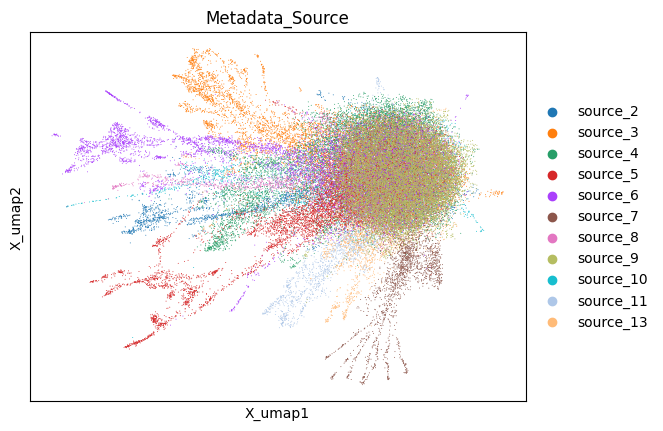

In [18]:
sc.pl.embedding(
    adata,
    "X_umap",
    color="Metadata_Source"
)

In [19]:
adata.write("../data/target2_wellres_featuresimputed_druginfoadded_pycytominer.h5ad")

/home/icb/tim.treis/miniconda/envs/jump/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/tim.treis/miniconda/envs/jump/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Metadata_compound'}, xlabel='X_umap1', ylabel='X_umap2'>

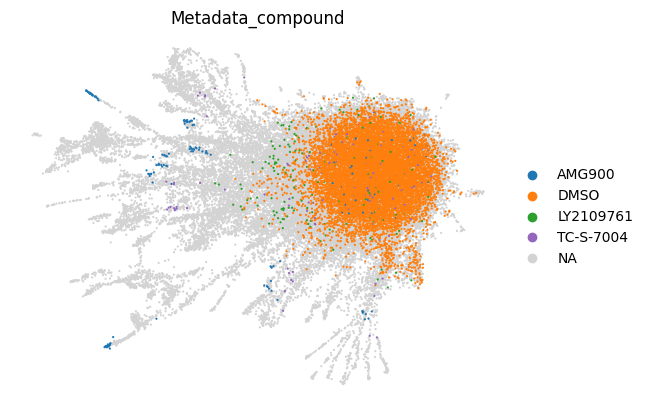

In [20]:
adata.obs["Metadata_compound"] = "Other"
adata.obs.loc[adata.obs["Metadata_InChIKey_standardized"] == "IAZDPXIOMUYVGZ-UHFFFAOYSA-N", "Metadata_compound"] = "DMSO"
adata.obs.loc[adata.obs["Metadata_InChIKey"] == "IVUGFMLRJOCGAS-UHFFFAOYSA-N", "Metadata_compound"] = "AMG900"
adata.obs.loc[adata.obs["Metadata_InChIKey"] == "OINGHOPGNMYCAB-INIZCTEOSA-N", "Metadata_compound"] = "NVS-PAK1-1"
adata.obs.loc[adata.obs["Metadata_InChIKey"] == "UREBDLICKHMUKA-CXSFZGCWSA-N", "Metadata_compound"] = "dexamethasone"
adata.obs.loc[adata.obs["Metadata_InChIKey"] == "IHLVSLOZUHKNMQ-UHFFFAOYSA-N", "Metadata_compound"] = "LY2109761"
adata.obs.loc[adata.obs["Metadata_InChIKey"] == "KPBNHDGDUADAGP-VAWYXSNFSA-N", "Metadata_compound"] = "FK-866"
adata.obs.loc[adata.obs["Metadata_InChIKey"] == "LOUPRKONTZGTKE-LHHVKLHASA-N", "Metadata_compound"] = "quinidine"
adata.obs.loc[adata.obs["Metadata_InChIKey"] == "CQKBSRPVZZLCJE-UHFFFAOYSA-N", "Metadata_compound"] = "TC-S-7004"
adata.obs.loc[adata.obs["Metadata_InChIKey"] == "SRVFFFJZQVENJC-IHRRRGAJSA-N", "Metadata_compound"] = "aloxistatin"

adata.obs["Metadata_compound"] = adata.obs["Metadata_compound"].astype("category")

sc.pl.embedding(
    adata,
    "X_umap",
    color="Metadata_compound",
    groups=["DMSO", "AMG900", "NVS-PAK1-1", "dexamethasone", "LY2109761", "FK-866", "quinidine", "TC-S-7004", "aloxistatin"],
    s=10,
    show=False,
    sort_order=True,
    frameon=False,
)

/home/icb/tim.treis/miniconda/envs/jump/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/tim.treis/miniconda/envs/jump/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


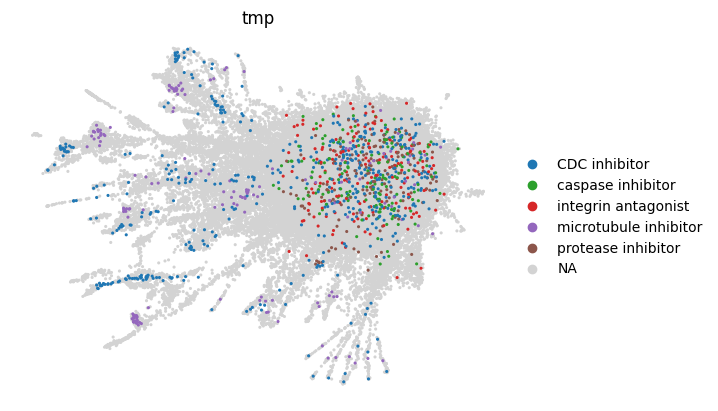

In [21]:
adata.obs["Metadata_moa"] = adata.obs["Metadata_moa"].astype("category")
examples = ["CDC inhibitor", "caspase inhibitor", "integrin antagonist", "microtubule inhibitor", "protease inhibitor"]

# filter to moas to be shown so scanpy doesn't default to grey due to too many categories
adata.obs["tmp"] = [moa if moa in examples else "Other" for moa in adata.obs["Metadata_moa"].values]

sc.pl.embedding(
    adata,
    "X_umap",
    color="tmp",
    groups=examples,
    cmap="tab10",
    s=20,
    frameon=False,
)